# USGS API Testing

In [1]:
import requests
import os
import pandas as pd
import copy
import matplotlib.pyplot as plt
import random

## Get API key using credentials

In [2]:
#os.environ['API_USER'] = 'aaa'
#os.environ['API_PASSWORD'] = 'aaa'

username = os.environ.get('API_USER')
password = os.environ.get('API_PASSWORD')

login_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/login', json = {"username": username, "password": password})
auth_code = login_response.json()['data']

## Search for scenes

In [3]:

payload = { 
    "datasetName": "landsat_ard_tile_c2" ,
    "metadataType": "full",
    "maxResults": 1000,
    "sceneFilter": {
        "acquisitionFilter": {
            "start": "2018-01-01",
            "end": "2023-01-01"
        },
        "cloudCoverFilter": {
            "max": 3,
            "min": 0,
            "includeUnknown": False
        },
        "spatialFilter": {
           "filterType": "mbr",
           "lowerLeft": {
                   "latitude": 39.92817,
                   "longitude": -74.66431
           },
           "upperRight": {
                   "latitude": 41.54334,
                   "longitude": -72.50449
           }
        }
    }
}

search_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/scene-search', json = payload, headers={"X-Auth-Token": auth_code})

print(f'{search_response.status_code=}')
print(f'{search_response.json()["errorCode"]=}')
print(f'{search_response.json()["errorMessage"]=}')

search_response_json_data = search_response.json()['data']

search_response.status_code=200
search_response.json()["errorCode"]=None
search_response.json()["errorMessage"]=None


### Clean response and convert to DF

In [4]:
search_response_results = search_response_json_data['results']

# unpack metadata , flatten browse field
meta_info = []
for response in search_response_results:

    for meta in response['metadata']:
        meta_info.append({'fieldName': meta['fieldName'], 'id': meta['id'], 'dictionaryLink': meta['dictionaryLink']})
        response['meta.' + meta['fieldName']] = meta['value']
    del response['metadata']

    for idx, b in enumerate(response['browse']):
        response[f'browse_{idx}'] = b
    del response['browse']

meta_info_df = pd.DataFrame.from_records(meta_info).drop_duplicates()
meta_info_df.to_csv("../data/input/api/metadata_info.csv", index = False)

search_response_results_df = pd.DataFrame.from_records(
    pd.json_normalize(search_response_results, sep=".").to_dict(orient='records')
    ).sort_values(by=['cloudCover'])
search_response_results_df.to_csv("../data/input/api/scene-search-responses.csv", index = False)

<Axes: title={'center': 'distribution of scenes from request for 1000 between 2018-2022'}, xlabel='date', ylabel='count'>

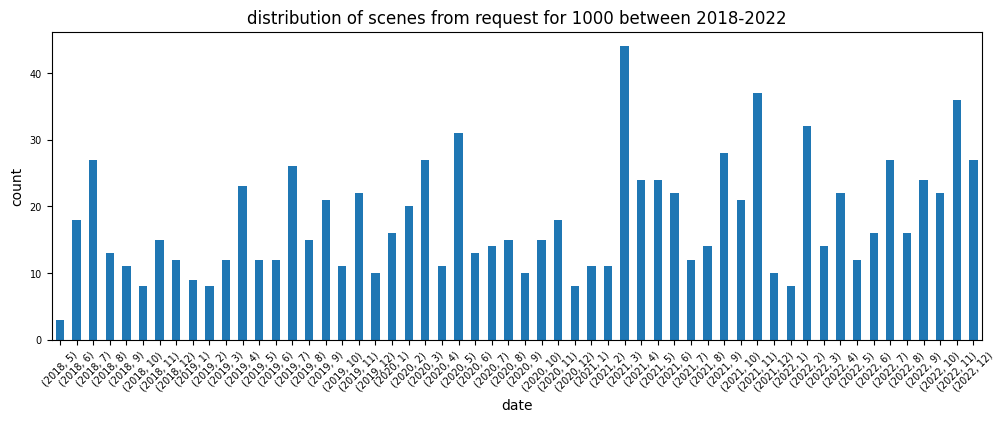

In [5]:
search_response_results_df["meta.Acquisition Date"] = search_response_results_df["meta.Acquisition Date"].astype("datetime64")
search_response_results_df.loc[:, "meta.Acquisition Date"].groupby(
    [search_response_results_df["meta.Acquisition Date"].dt.year, search_response_results_df["meta.Acquisition Date"].dt.month]
    ).count().plot(kind='bar', fontsize = '7', rot=45, figsize=(12, 4), xlabel='date', ylabel='count', title = 'distribution of scenes from request for 1000 between 2018-2022')

### Collect IDs for download

In [6]:
entityIds = []
for response in search_response_results:
    entityIds.append(response['entityId'])
entityIds = list(set(entityIds))

## Get download options from API 

In [7]:
payload = {'datasetName' : 'landsat_ard_tile_c2', 'entityIds' : random.sample(entityIds, 100)}
                            
options_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/download-options', json = payload, headers={"X-Auth-Token": auth_code})
options_reponse_data = options_response.json()['data']

print(f'{options_response.status_code=}')
print(f'{options_response.json()["errorCode"]=}')
print(f'{options_response.json()["errorMessage"]=}')

options_response.status_code=200
options_response.json()["errorCode"]=None
options_response.json()["errorMessage"]=None


### Clean/flatten response and convert to DF

In [8]:
flatter_options_response_data = []
for record in options_reponse_data:
    for secondary in record['secondaryDownloads']:

        copy_record = copy.deepcopy(record)
        copy_record['secondaryDownloads'] = secondary
        
        flatter_options_response_data.append(copy_record)

options_response_df = pd.DataFrame.from_records(
    pd.json_normalize(flatter_options_response_data, sep=".").to_dict(orient='records')
    )
options_response_df.to_csv("../data/input/api/download-options-responses.csv", index = False)

In [9]:
# what are the bundle names?
options_response_df['productName'].unique()

array(['C2 ARD Tile Quality Assessment Bundle Download',
       'C2 ARD Tile Metadata Bundle Download',
       'C2 ARD Tile Surface Reflectance Bundle Download',
       'C2 ARD Tile Surface Temperature Bundle Download',
       'C2 ARD Tile Top of Atmosphere Reflectance Bundle Download',
       'C2 ARD Tile Brightness Temperature Bundle Download'], dtype=object)

### Filter download options for 'available'

In [10]:
avail_options_response_df = options_response_df[options_response_df['available']]

## Use API to request download information

In [11]:
# filter for available downloads
avail_options_response_df = avail_options_response_df.rename(columns={"id": "productId"})

codes_df = avail_options_response_df[['entityId', 'productId']].drop_duplicates()
codes_dict = codes_df.to_dict('records')

label = "download-test"
payload = {'downloads' : codes_dict, 'label' : label}

download_response = requests.post('https://m2m.cr.usgs.gov/api/api/json/stable/download-request', json = payload, headers={"X-Auth-Token": auth_code})
download_response_data = download_response.json()['data']

print(f'{download_response.status_code=}')
print(f'{download_response.json()["errorCode"]=}')
print(f'{download_response.json()["errorMessage"]=}')


download_response.status_code=200
download_response.json()["errorCode"]=None
download_response.json()["errorMessage"]=None


### Count responses and check for failures or pending downloads

In [12]:
count_responses = {k: len(download_response_data[k]) for k in ['availableDownloads', 'duplicateProducts', 'preparingDownloads', 'failed', 'newRecords']}
print(count_responses)

{'availableDownloads': 600, 'duplicateProducts': 0, 'preparingDownloads': 0, 'failed': 0, 'newRecords': 600}


In [13]:
download_response_data['numInvalidScenes']

0

## Save download information DF

In [14]:
download_response_df = pd.DataFrame.from_dict(download_response_data['availableDownloads'])

# pull out entityId from URL
download_response_df[['downloadEntity', 'entityType']] = download_response_df['url'].str.extract(r'.*landsat_product_id=(.*)_(.*)&.*')

# pivot df
download_response_df = download_response_df.pivot(index = ['downloadEntity'], columns=['entityType'], values=['url', 'downloadId'])
download_response_df.columns = ["_".join(tup) for tup in download_response_df.columns.to_flat_index()]

download_response_df.to_csv('../data/input/api/downloads-request-reponses.csv')